<a href="https://colab.research.google.com/github/szezlong/Alzheimer_MRI_Classification/blob/main/Brain_MRI_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import keras
import plotly.express as px
import numpy as np

from random import randrange

import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy


In [2]:
directory = "/content/drive/MyDrive/Colab Notebooks/Dataset"
class_names = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

In [ ]:
no_dict={}
for dirpath, dirnames, filenames in os.walk(directory):
  no_dict[dirpath] = len(filenames)
paths = list(no_dict.keys())
categories = [[folder for folder in path.split('/')][-1] for path in paths]
data   = [float(v) for v in no_dict.values()]
px.pie(names=categories[1:], values=data[1:], width=500, height=400)

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

image_set = ImageDataGenerator(validation_split=0.2)
train = image_set.flow_from_directory(
    directory,
    batch_size = 32,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=47,
    subset='training',
    class_mode='sparse'
    )

eval = image_set.flow_from_directory(
    directory,
    batch_size = 32,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=47,
    subset='validation',
    class_mode='sparse'
    )

Found 5153 images belonging to 4 classes.
Found 1287 images belonging to 4 classes.



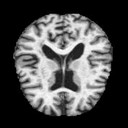
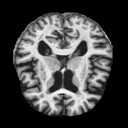
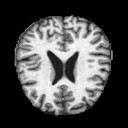
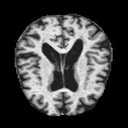
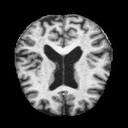


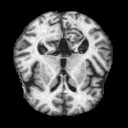
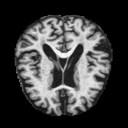
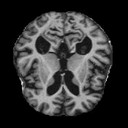
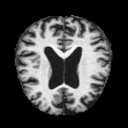
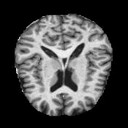


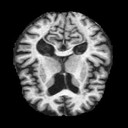
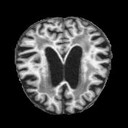
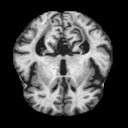
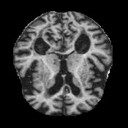
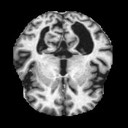


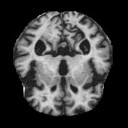
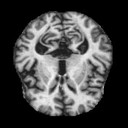
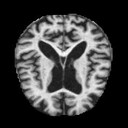
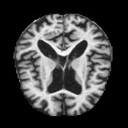
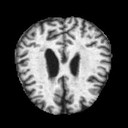

In [ ]:
from skimage import io

def show_samples(category):
  no_samples = 5
  cat_path = os.path.join(directory, category)
  img_names = [image for image in os.listdir(cat_path) if image.endswith('.jpg')]
  img_list = []
  for i in range(no_samples):
    img_path = (os.path.join(cat_path, img_names[randrange(len(img_names))]))
    img_list.append(io.imread(img_path))

  data=(np.array(img_list)[:5, :, :])
  fig = px.imshow(data,
                  title=f'<b>Brain MRI samples for {category}<b>',
                  facet_col=0,
                  binary_string=True,
                  facet_col_wrap=no_samples,
                  height=400,
                  width=1200)
  fig.for_each_annotation(lambda a: a.update(text=f'Sample {int(a.text.split("=")[-1]) +1}'))
  fig.update_layout(title_x=0.5)
  fig.update_xaxes(showticklabels=False)
  fig.update_yaxes(showticklabels=False)
  fig.show()

for category in class_names:
  show_samples(category)

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

total = sum(no_dict.values())
dataset = dataset.shuffle(buffer_size=7000)
train = dataset.take(int(0.7 * total))
test_dataset = dataset.skip(int(0.7 * total))
eval = test_dataset.skip(int(0.15 * total))
test = test_dataset.take(int(0.15 * total))

y_train = tf.concat(list(map(lambda x: x[1], train)), axis=0)
print(y_train)

tf.Tensor([3 2 3 ... 3 3 2], shape=(6440,), dtype=int32)


In [ ]:
from sklearn.utils import compute_class_weight
import numpy as np

class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))
class_weights

{0: 1.796875, 1: 25.15625, 2: 0.5, 3: 0.7123893805309734}

In [ ]:
class_weights = {
    0: 1.796875,
    1: 25.15625,
    2: 0.5,
    3: 0.7123893805309734
}
class_weights

{0: 1.796875, 1: 25.15625, 2: 0.5, 3: 0.7123893805309734}

In [ ]:
def build_model():
  model = models.Sequential()
  model.add(keras.layers.experimental.preprocessing.Rescaling(1./255,
                                      input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))

  model.add(layers.Conv2D(16, (3, 3),
                          activation='relu',
                          padding='same',
                          input_shape=(128, 128, 3),
                          kernel_initializer='he_normal',
                          ))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3),
                          activation='relu',
                          padding='same',
                          input_shape=(128, 128, 3),
                          kernel_initializer='he_normal',
                          ))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.20))
  model.add(layers.Conv2D(128, (3, 3),
                          activation='relu',
                          padding='same',
                          input_shape=(128, 128, 3),
                          kernel_initializer='he_normal',
                          ))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(keras.layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
model = build_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 32)       

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def checkpoint_callback():
  checkpoint_path = '/tmp/checkpoint'
  model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                    save_weights_only=False,
                                    frequency='epoch',
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    verbose=1)
  return model_checkpoint

def early_stopping(patience):
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=patience,
                                                 verbose=1)
  return es_callback

In [ ]:
EPOCHS = 20
# checkpoint_callback = checkpoint_callback()
# early_stopping = early_stopping(patience=5)
# callbacks=[checkpoint_callback, early_stopping]

history = model.fit(
    train,
    epochs=EPOCHS,
    validation_data=eval,
    # class_weight = class_weights,
    verbose=1,
    # callbacks=callbacks
    )

Epoch 1/20
162/162 [==============================] - 133s 823ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 1.7236 - val_accuracy: 0.7125
Epoch 2/20
162/162 [==============================] - 134s 825ms/step - loss: 0.0137 - accuracy: 0.9950 - val_loss: 1.9618 - val_accuracy: 0.6845
Epoch 3/20
162/162 [==============================] - 131s 808ms/step - loss: 0.0226 - accuracy: 0.9918 - val_loss: 1.4661 - val_accuracy: 0.7288
Epoch 4/20
162/162 [==============================] - 131s 806ms/step - loss: 0.0252 - accuracy: 0.9926 - val_loss: 2.2254 - val_accuracy: 0.7172
Epoch 5/20
162/162 [==============================] - 132s 817ms/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 2.6317 - val_accuracy: 0.5991
Epoch 6/20
162/162 [==============================] - 130s 805ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 1.8150 - val_accuracy: 0.6993
Epoch 7/20
162/162 [==============================] - 133s 821ms/step - loss: 0.0103 - accuracy: 0.9977 - val_loss: 1.9266 -

In [ ]:
acc = history.history['accuracy']
los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs=range(len(acc))

In [ ]:
import plotly.graph_objects as go

fig = px.line(title='Accuracy and loss of training data', width=600, height=400)
fig.add_trace(go.Scatter(x=list(epochs), y=acc, name='Accuracy'))
fig.add_trace(go.Scatter(x=list(epochs), y=los, name='Loss'))
fig.update_layout(yaxis_range=[0,1])
fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
fig = px.line(title='Accuracy and loss of validation data', width=600, height=400)
fig.add_trace(go.Scatter(x=list(epochs), y=val_acc, name='Accuracy'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_loss, name='Loss'))
# fig.update_layout(yaxis_range=[0,1])
fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
fig = px.line(title='Accuracy of training and validation data', width=600, height=400)
fig.add_trace(go.Scatter(x=list(epochs), y=acc, name='training_accuracy'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_acc, name='validation_accuracy'))
# fig.update_layout(yaxis_range=[0,1])
fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
test = image_set.flow_from_directory(
    directory,
    # labels='inferred',
    # label_mode='categorical',
    color_mode='grayscale',
    batch_size = 32,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=47,
    subset='validation',
    )

Found 1287 images belonging to 4 classes.


In [ ]:
loss, accuracy = model.evaluate(test)
print(loss)
print(accuracy)

3.4523639229477427
0.39875713


In [ ]:
from PIL import Image

def preprocess_img(path):
  img = Image.open(path).convert('L')
  img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
  return img

test_path = '/content/dementia.png'
test_img = preprocess_img(test_path)

In [ ]:
test_path = '/content/AD.PNG'
test_img = preprocess_img(test_path)

In [ ]:
from plotly.subplots import make_subplots

def show_prediction(image, prob_dict):
  fig = make_subplots(rows=1, cols=2, specs=[[{"type": "image"}, {"type": "pie"}]])
  img = io.imread(test_path)
  fig.add_trace(go.Image(z=img), 1, 1)
  fig.add_trace(go.Pie(labels=list(prob_dict.keys()),
                       values=list(prob_dict.values()),
                       domain=dict(x=[0.5, 1.0]),
                       ), 1, 2)
  fig.update_layout(height=350, width=700, title_text="<b>     Brain MRI Scan                        Prediction of Alzheimer<b>")
  # fig.update_layout(title_x=0.5)
  fig.update_layout(
    margin=dict(l=30, r=30, t=50, b=50),
  )

  fig.update_xaxes(showticklabels=False)
  fig.update_yaxes(showticklabels=False)
  fig.show()

def get_prediction(image):
  pred = model.predict(tf.expand_dims(image, 0))[0]
  prob = list(tf.nn.softmax(pred).numpy())
  print(f'\nMost probable is: {class_names[np.argmax(tf.nn.softmax(pred))]}\n')
  prob_dict = dict(zip(class_names, prob))
  show_prediction(image, prob_dict)

In [ ]:
get_prediction(test_img)

1/1 [==============================] - 0s 30ms/step

Most probable is: Mild_Demented



In [ ]:
get_prediction(test_img)

1/1 [==============================] - 0s 54ms/step
Most probable is: Non_Demented
